In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import plot_tree
from sklearn.metrics import precision_score, recall_score, f1_score

file_path = '/data/datasets/rishi/symptom_classification/training_review_tc_3.14.23.xlsx'

random_state_values = random.sample(range(1, 500), 10)
print(random_state_values)

[317, 124, 51, 8, 61, 290, 64, 338, 443, 465]


Total patients used to train the tree: 155
Number of Negative samples: 102
Number of Positive samples: 53

Model with max depth 3 and Random State 317
Accuracy: 0.596
Precision: 0.391
Sensitivity: 0.643
Specificity: 0.576
NPV: 0.792
F1 Score: 0.486
AUC: 0.665


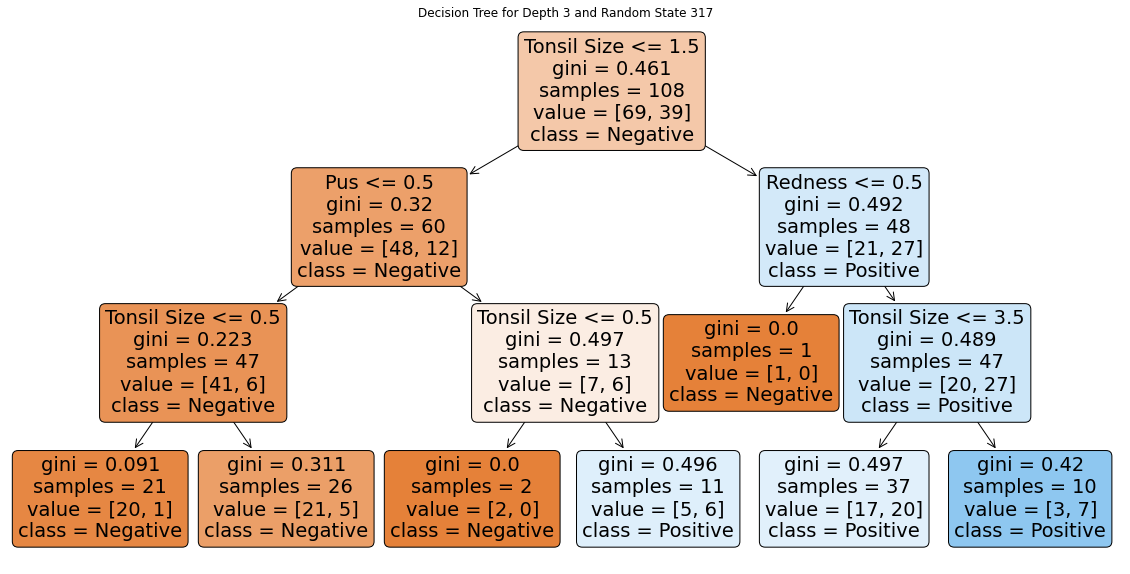


Model with max depth 3 and Random State 124
Accuracy: 0.574
Precision: 0.348
Sensitivity: 0.615
Specificity: 0.559
NPV: 0.792
F1 Score: 0.444
AUC: 0.640


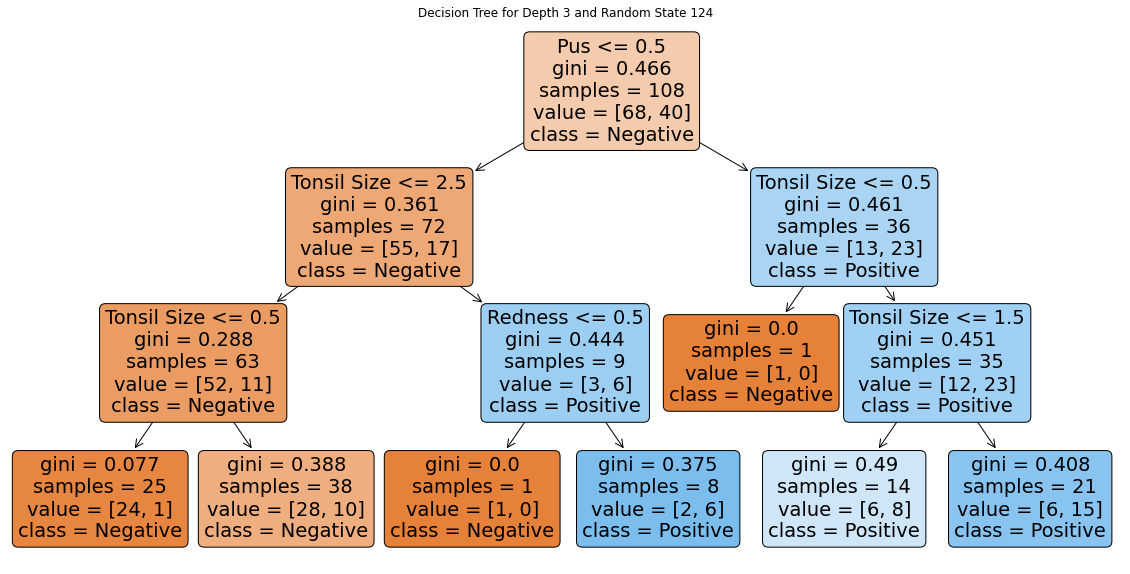


Model with max depth 3 and Random State 51
Accuracy: 0.596
Precision: 0.500
Sensitivity: 0.263
Specificity: 0.821
NPV: 0.622
F1 Score: 0.345
AUC: 0.613


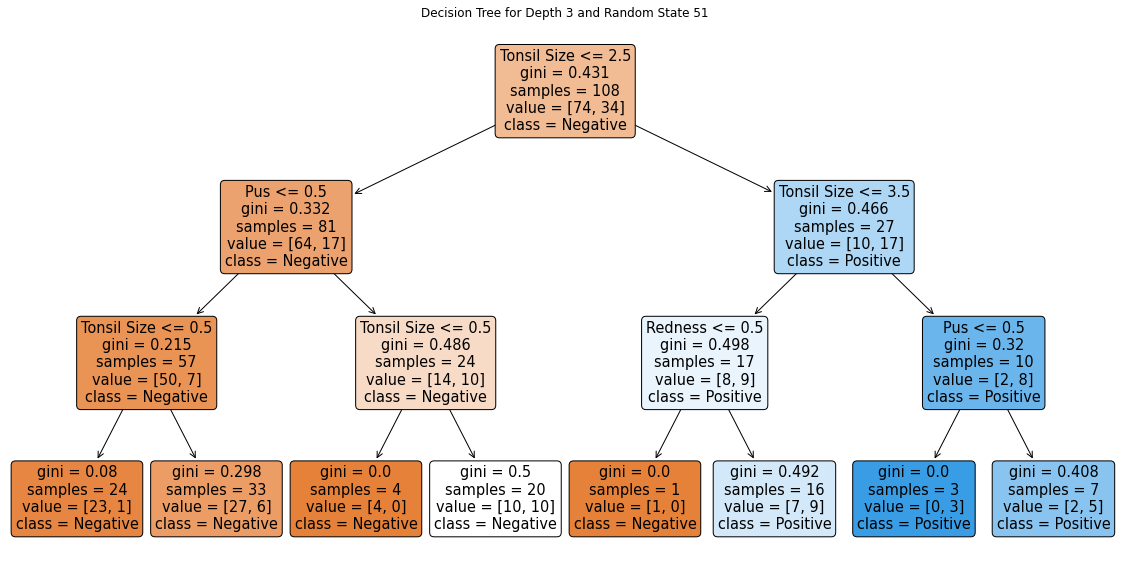


Average Metrics Across All Trees (input max aggregated):
Accuracy: 0.589
Precision: 0.413
Sensitivity: 0.507
Specificity: 0.652
NPV: 0.735
F1 Score: 0.425
AUC: 0.639


In [13]:
'''AGGREGATED MAX INPUT PER PATIENT'''

# Load and preprocess the dataset
df = pd.read_excel(file_path)

# Remove invalid entries
df = df[df['Pus'] != 99]
df = df[df['Redness'] != 99]
df = df[df['Tonsil Size'] != 99]

# Extract patient ID from frame name
df['Patient_ID'] = df['Frame Name'].str.extract(r'^(.*?)-frame_')

# Aggregate data for each patient by taking the max value of each metric
agg_df = df.groupby('Patient_ID').agg({
    'Pus': 'max',
    'Redness': 'max',
    'Tonsil Size': 'max', # test mean
    'Strep Positive': 'max'
}).reset_index()

# Now, each row of agg_df represents a patient rather than a frame
X = agg_df[['Pus', 'Redness', 'Tonsil Size']]
y = agg_df['Strep Positive']

total_samples = len(agg_df)
negative_samples = len(agg_df[agg_df['Strep Positive'] == 0])
positive_samples = len(agg_df[agg_df['Strep Positive'] == 1])

print(f"Total patients used to train the tree: {total_samples}")
print(f"Number of Negative samples: {negative_samples}")
print(f"Number of Positive samples: {positive_samples}")

patient_ids = agg_df['Patient_ID'].unique()
max_depths = [3, 3, 3]

metrics_dict = {
    "Accuracy": [],
    "Precision": [],
    "Sensitivity": [],
    "Specificity": [],
    "NPV": [],
    "F1 Score": [],
    "AUC": []
}

for depth, random_state in zip(max_depths, random_state_values):
    # Stratify data by patient
    train_ids, test_ids = train_test_split(patient_ids, test_size=0.3, random_state=random_state)

    train_df = agg_df[agg_df['Patient_ID'].isin(train_ids)]
    test_df = agg_df[agg_df['Patient_ID'].isin(test_ids)]

    X_train = train_df[['Pus', 'Redness', 'Tonsil Size']]
    y_train = train_df['Strep Positive']

    X_test = test_df[['Pus', 'Redness', 'Tonsil Size']]
    y_test = test_df['Strep Positive']

    # Train model
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    probs = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, probs)

    TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
    specificity = TN / (TN + FP)
    npv = TN / (TN + FN)

    # Print metrics
    print(f"\nModel with max depth {depth} and Random State {random_state}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Sensitivity: {recall:.3f}")
    print(f"Specificity: {specificity:.3f}")
    print(f"NPV: {npv:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"AUC: {auc:.3f}")

    metrics_dict["Accuracy"].append(accuracy)
    metrics_dict["Precision"].append(precision)
    metrics_dict["Sensitivity"].append(recall)
    metrics_dict["Specificity"].append(specificity)
    metrics_dict["NPV"].append(npv)
    metrics_dict["F1 Score"].append(f1)
    metrics_dict["AUC"].append(auc)

    # Plot tree
    plt.figure(figsize=(20,10))
    plot_tree(clf, filled=True, feature_names=X.columns, class_names=["Negative", "Positive"], rounded=True)
    plt.title(f'Decision Tree for Depth {depth} and Random State {random_state}')
    plt.show()

print("\nAverage Metrics Across All Trees (input max aggregated):")
for metric_name, values in metrics_dict.items():
    avg_value = sum(values) / len(values)
    print(f"{metric_name}: {avg_value:.3f}")


Total patients used to train the tree: 155
Number of Negative samples: 102
Number of Positive samples: 53

Model with max depth 3 and Random State 317
Accuracy: 0.596
Precision: 0.391
Sensitivity: 0.643
Specificity: 0.576
NPV: 0.792
F1 Score: 0.486
AUC: 0.662


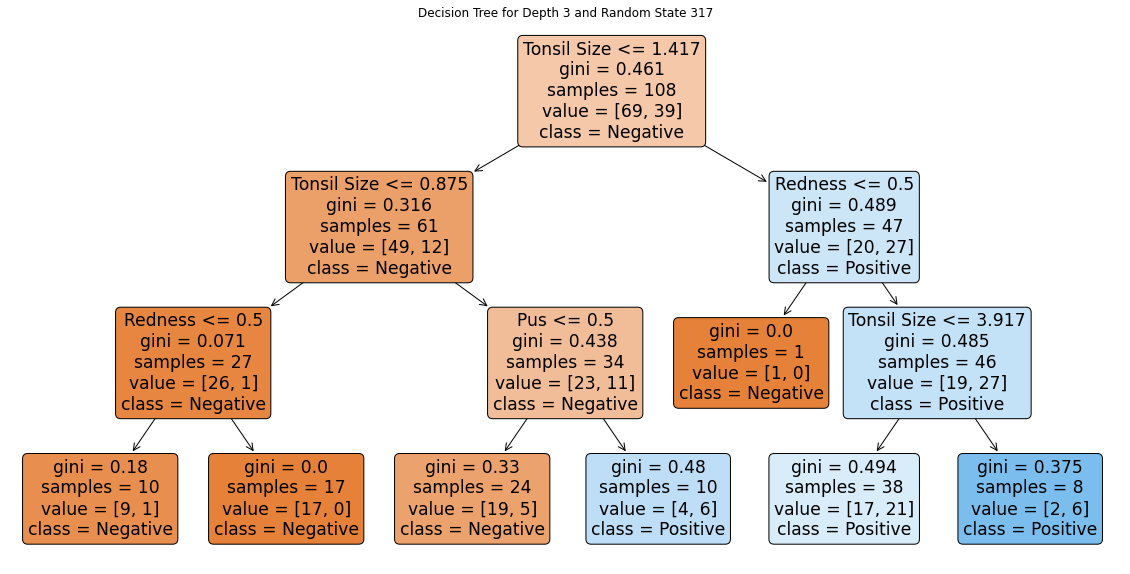


Model with max depth 3 and Random State 124
Accuracy: 0.574
Precision: 0.333
Sensitivity: 0.538
Specificity: 0.588
NPV: 0.769
F1 Score: 0.412
AUC: 0.630


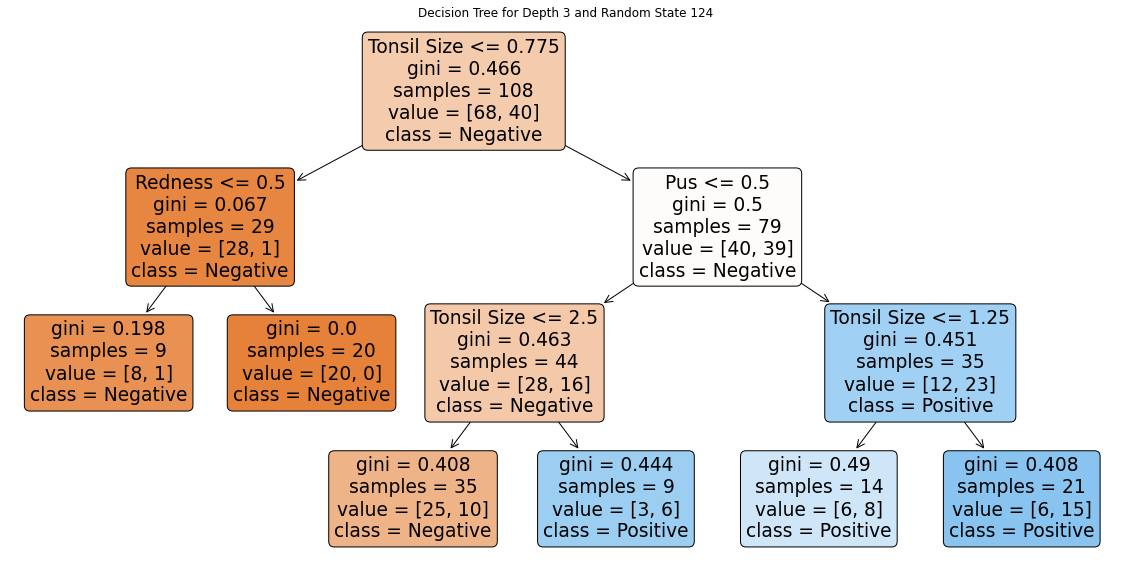


Model with max depth 3 and Random State 51
Accuracy: 0.596
Precision: 0.500
Sensitivity: 0.474
Specificity: 0.679
NPV: 0.655
F1 Score: 0.486
AUC: 0.607


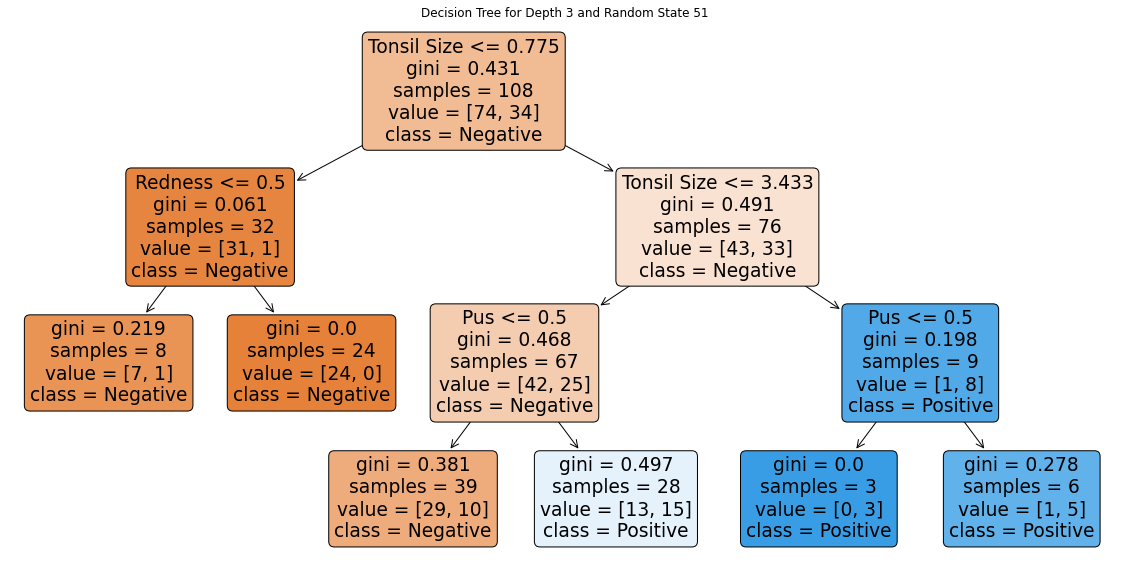


Average Metrics Across All Trees (input aggregated w/mean tonsil size):
Accuracy: 0.589
Precision: 0.408
Sensitivity: 0.552
Specificity: 0.614
NPV: 0.739
F1 Score: 0.462
AUC: 0.633


In [14]:
'''AGGREGATED MAX INPUT + MEAN TONSIL SIZE PER PATIENT'''

# Load and preprocess the dataset
df = pd.read_excel(file_path)

# Remove invalid entries
df = df[df['Pus'] != 99]
df = df[df['Redness'] != 99]
df = df[df['Tonsil Size'] != 99]

# Extract patient ID from frame name
df['Patient_ID'] = df['Frame Name'].str.extract(r'^(.*?)-frame_')

# Aggregate data for each patient by taking the max value of each metric
agg_df = df.groupby('Patient_ID').agg({
    'Pus': 'max',
    'Redness': 'max',
    'Tonsil Size': 'mean',
    'Strep Positive': 'max'
}).reset_index()

# Now, each row of agg_df represents a patient rather than a frame
X = agg_df[['Pus', 'Redness', 'Tonsil Size']]
y = agg_df['Strep Positive']

total_samples = len(agg_df)
negative_samples = len(agg_df[agg_df['Strep Positive'] == 0])
positive_samples = len(agg_df[agg_df['Strep Positive'] == 1])

print(f"Total patients used to train the tree: {total_samples}")
print(f"Number of Negative samples: {negative_samples}")
print(f"Number of Positive samples: {positive_samples}")

patient_ids = agg_df['Patient_ID'].unique()
max_depths = [3, 3, 3]

metrics_dict = {
    "Accuracy": [],
    "Precision": [],
    "Sensitivity": [],
    "Specificity": [],
    "NPV": [],
    "F1 Score": [],
    "AUC": []
}

for depth, random_state in zip(max_depths, random_state_values):
    # Stratify data by patient
    train_ids, test_ids = train_test_split(patient_ids, test_size=0.3, random_state=random_state)

    train_df = agg_df[agg_df['Patient_ID'].isin(train_ids)]
    test_df = agg_df[agg_df['Patient_ID'].isin(test_ids)]

    X_train = train_df[['Pus', 'Redness', 'Tonsil Size']]
    y_train = train_df['Strep Positive']

    X_test = test_df[['Pus', 'Redness', 'Tonsil Size']]
    y_test = test_df['Strep Positive']

    # Train model
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    probs = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, probs)

    TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
    specificity = TN / (TN + FP)
    npv = TN / (TN + FN)

    # Print metrics
    print(f"\nModel with max depth {depth} and Random State {random_state}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Sensitivity: {recall:.3f}")
    print(f"Specificity: {specificity:.3f}")
    print(f"NPV: {npv:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"AUC: {auc:.3f}")

    metrics_dict["Accuracy"].append(accuracy)
    metrics_dict["Precision"].append(precision)
    metrics_dict["Sensitivity"].append(recall)
    metrics_dict["Specificity"].append(specificity)
    metrics_dict["NPV"].append(npv)
    metrics_dict["F1 Score"].append(f1)
    metrics_dict["AUC"].append(auc)

    # Plot tree
    plt.figure(figsize=(20,10))
    plot_tree(clf, filled=True, feature_names=X.columns, class_names=["Negative", "Positive"], rounded=True)
    plt.title(f'Decision Tree for Depth {depth} and Random State {random_state}')
    plt.show()

print("\nAverage Metrics Across All Trees (input aggregated w/mean tonsil size):")
for metric_name, values in metrics_dict.items():
    avg_value = sum(values) / len(values)
    print(f"{metric_name}: {avg_value:.3f}")


Total patients used to train the tree: 526
Number of Negative samples: 336
Number of Positive samples: 190

Model with max depth 3 and Random State 317
Accuracy: 0.617
Precision: 0.500
Sensitivity: 0.500
Specificity: 0.690
NPV: 0.690
F1 Score: 0.500
AUC: 0.700


<ipython-input-15-a99197344ccb>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predicted_Prob'] = probs_test


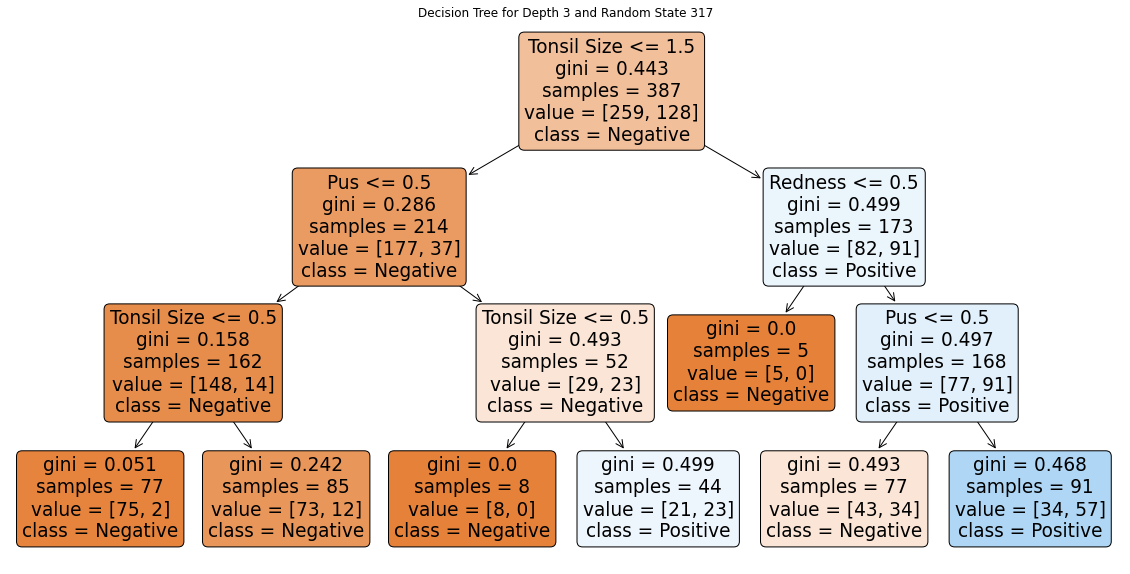

<ipython-input-15-a99197344ccb>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predicted_Prob'] = probs_test



Model with max depth 3 and Random State 124
Accuracy: 0.660
Precision: 0.562
Sensitivity: 0.500
Specificity: 0.759
NPV: 0.710
F1 Score: 0.529
AUC: 0.740


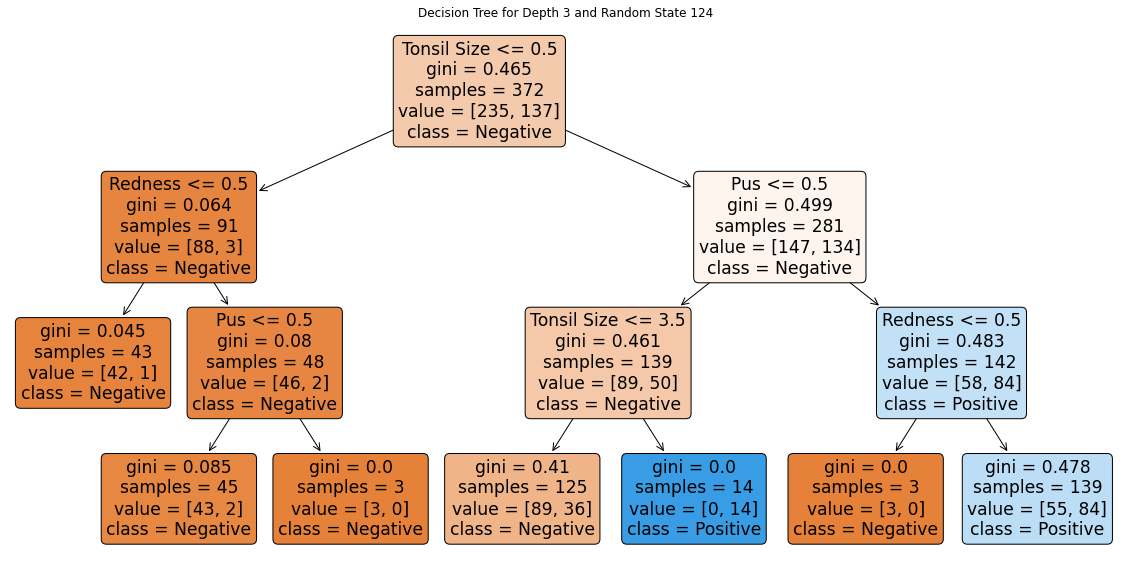

<ipython-input-15-a99197344ccb>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predicted_Prob'] = probs_test



Model with max depth 3 and Random State 51
Accuracy: 0.596
Precision: 0.526
Sensitivity: 0.500
Specificity: 0.667
NPV: 0.643
F1 Score: 0.513
AUC: 0.632


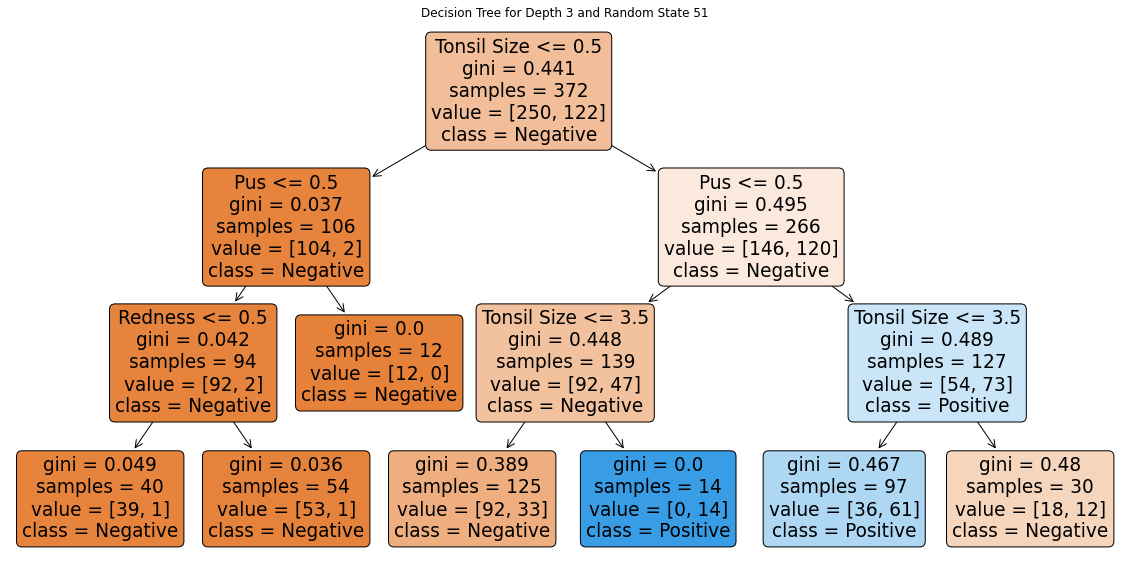


Average Metrics Across All Trees (output aggregated):
Accuracy: 0.624
Precision: 0.530
Sensitivity: 0.500
Specificity: 0.705
NPV: 0.681
F1 Score: 0.514
AUC: 0.691


In [15]:
import random
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import plot_tree
from sklearn.metrics import precision_score, recall_score, f1_score

'''AGGREGATED OUTPUT PER PATIENT'''

df = pd.read_excel(file_path)

# Remove invalid entries
df = df[df['Pus'] != 99]
df = df[df['Redness'] != 99]
df = df[df['Tonsil Size'] != 99]

# Extract patient ID from frame name
df['Patient_ID'] = df['Frame Name'].str.extract(r'^(.*?)-frame_')

# Data exploration
patient_ids = df['Patient_ID'].unique()
total_samples = len(df)
negative_samples = len(df[df['Strep Positive'] == 0])
positive_samples = len(df[df['Strep Positive'] == 1])

print(f"Total patients used to train the tree: {total_samples}")
print(f"Number of Negative samples: {negative_samples}")
print(f"Number of Positive samples: {positive_samples}")
max_depths = [3, 3, 3]

metrics_dict = {
    "Accuracy": [],
    "Precision": [],
    "Sensitivity": [],
    "Specificity": [],
    "NPV": [],
    "F1 Score": [],
    "AUC": []
}

for depth, random_state in zip(max_depths, random_state_values):
    # Stratify data by patient
    train_ids, test_ids = train_test_split(patient_ids, test_size=0.3, random_state=random_state)

    train_df = df[df['Patient_ID'].isin(train_ids)]
    test_df = df[df['Patient_ID'].isin(test_ids)]

    X_train = train_df[['Pus', 'Redness', 'Tonsil Size']]
    y_train = train_df['Strep Positive']

    X_test = test_df[['Pus', 'Redness', 'Tonsil Size']]
    y_test = test_df['Strep Positive']

    # Train model
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_train, y_train)

    # Predict on test set
    probs_test = clf.predict_proba(X_test)[:, 1]

    # Add predictions to test_df for aggregation
    test_df['Predicted_Prob'] = probs_test

    # Aggregate predictions by patient
    aggregated_predictions = test_df.groupby('Patient_ID').agg({
        'Predicted_Prob': 'mean',
        'Pus': ['var', 'count'],
        'Redness': 'var',
        'Tonsil Size': 'var'
    }).reset_index()

    # Flatten the multi-level column names
    aggregated_predictions.columns = ['_'.join(col).strip() for col in aggregated_predictions.columns.values]

    # Predicted label based on mean probability
    aggregated_predictions['Predicted_Label'] = (aggregated_predictions['Predicted_Prob_mean'] > 0.5).astype(int)

    # Get actual labels for each patient
    true_labels = test_df.groupby('Patient_ID').agg({
        'Strep Positive': 'max'
    }).reset_index()

    # Calculate metrics
    y_test_aggregated = true_labels['Strep Positive']
    y_pred_aggregated = aggregated_predictions['Predicted_Label']

    accuracy = accuracy_score(y_test_aggregated, y_pred_aggregated)
    precision = precision_score(y_test_aggregated, y_pred_aggregated)
    recall = recall_score(y_test_aggregated, y_pred_aggregated)
    f1 = f1_score(y_test_aggregated, y_pred_aggregated)
    auc = roc_auc_score(y_test_aggregated, aggregated_predictions['Predicted_Prob_mean'])

    TN, FP, FN, TP = confusion_matrix(y_test_aggregated, y_pred_aggregated).ravel()
    specificity = TN / (TN + FP)
    npv = TN / (TN + FN)

    # Print metrics
    print(f"\nModel with max depth {depth} and Random State {random_state}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Sensitivity: {recall:.3f}")
    print(f"Specificity: {specificity:.3f}")
    print(f"NPV: {npv:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"AUC: {auc:.3f}")

    metrics_dict["Accuracy"].append(accuracy)
    metrics_dict["Precision"].append(precision)
    metrics_dict["Sensitivity"].append(recall)
    metrics_dict["Specificity"].append(specificity)
    metrics_dict["NPV"].append(npv)
    metrics_dict["F1 Score"].append(f1)
    metrics_dict["AUC"].append(auc)

    # Plot tree
    plt.figure(figsize=(20,10))
    plot_tree(clf, filled=True, feature_names=X.columns, class_names=["Negative", "Positive"], rounded=True)
    plt.title(f'Decision Tree for Depth {depth} and Random State {random_state}')
    plt.show()

print("\nAverage Metrics Across All Trees (output aggregated):")
for metric_name, values in metrics_dict.items():
    avg_value = sum(values) / len(values)
    print(f"{metric_name}: {avg_value:.3f}")